In [1]:
# airregio_graph_crm.py
import operator
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

from typing import Annotated, TypedDict, Sequence, Optional
from langchain_core.messages import BaseMessage

from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader


import os.path

In [2]:
load_dotenv(override=True)
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Extract Data from Chat"

gpt = "gpt-4o-mini"
# llm = ChatOpenAI(model=gpt, temperature=0.2)
llama_3_2 = "llama-3.2-90b-vision-preview"
llm = ChatGroq(model=llama_3_2, temperature=0.2)

In [3]:
def process_docs_and_get_retriever(
    doc_path: str,
    persist_directory: str = "./data/rag/chroma_langchain_db",
    collection_name: str = "user_data",
    k: int = 4,
):
    """
    Load a document (PDF or DOCX), split its content, add it to a Chroma vector store, and return a retriever.
    
    Args:
        doc_path: Path to the document file (PDF or DOCX).
        persist_directory: Directory where the Chroma vector store will be persisted.
        collection_name: Name of the collection in the vector store.
        k: Number of documents to retrieve in similarity searches.
    
    Returns:
        A retriever object for querying the vector store.
    """
    # Step 1: Determine document type and load it
    if doc_path.endswith(".pdf"):
        try:
            loader = PyPDFLoader(doc_path)
            docs = loader.load_and_split()
        except Exception as e:
            print(f"Error loading PDF: {e}")
            return None
    elif doc_path.endswith(".docx"):
        try:
            loader = Docx2txtLoader(doc_path)
            docs = loader.load()
        except Exception as e:
            print(f"Error loading DOCX: {e}")
            return None
    else:
        print("Unsupported file format. Please provide a .pdf or .docx file.")
        return None

    # Step 2: Split the text into manageable chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=[
            "# ", "## ", "### ", "\n\n", "\n- ", ". ", " "
        ],
    )
    splits = text_splitter.split_documents(docs)

    # Step 3: Initialize or load Chroma vector store
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    if os.path.exists(persist_directory):
        # Load existing vector store
        vector_store = Chroma(
            persist_directory=persist_directory,
            embedding_function=embeddings,
            collection_name=collection_name,
        )
        # Add new documents to the existing vector store
        vector_store.add_documents(splits)
    else:
        # Create a new vector store and add documents
        vector_store = Chroma.from_documents(
            documents=splits,
            embedding=embeddings,
            persist_directory=persist_directory,
            collection_name=collection_name,
        )

    return "All Data added"

def process_text_as_retriever(text: str):
    """
    Process plain text, split it into chunks, add it to a Chroma vector store, and return a retriever.
    
    Args:
        text: Plain text to be added to the vector store.
    
    Returns:
        A retriever object for querying the vector store.
    """
    # Hard-coded parameters
    persist_directory = "./data/rag/chroma_langchain_db"
    collection_name = "user_data"
    k = 4

    # Step 1: Convert text into a Document object
    from langchain_core.documents import Document

    docs = [Document(page_content=text)]

    # Step 2: Split the text into manageable chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=[
            "# ", "## ", "### ", "\n\n", "\n- ", ". ", " "
        ],
    )
    splits = text_splitter.split_documents(docs)

    # Step 3: Initialize or load Chroma vector store
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    if os.path.exists(persist_directory):
        # Load existing vector store
        vector_store = Chroma(
            persist_directory=persist_directory,
            embedding_function=embeddings,
            collection_name=collection_name,
        )
        # Add new documents to the existing vector store
        vector_store.add_documents(splits)
    else:
        # Create a new vector store and add documents
        vector_store = Chroma.from_documents(
            documents=splits,
            embedding=embeddings,
            persist_directory=persist_directory,
            collection_name=collection_name,
        )

    # Step 4: Create and return the retriever
    retriever = vector_store.as_retriever(search_kwargs={"k": k})
    return retriever


def recreate_retriever(persist_directory: str = "./data/rag/chroma_langchain_db", collection_name: str = "user_data",):
    """
    Recreate the retriever dynamically using the metadata in the state.
    """

    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vector_store = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings,
        collection_name=collection_name,
    )
    return vector_store.as_retriever(search_kwargs={"k": 4})


In [4]:
# EXAMPLE OF USAGE RUN ONCE: 
doc_path="./data/docs/goldmine.docx"
retriever_doc = process_docs_and_get_retriever(doc_path)



In [ ]:
#retriever = recreate_retriever()
#retriever.invoke('ASGM')

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


[Document(metadata={'source': './data/docs/goldmine.docx'}, page_content='# Challenges and Opportunities in ASGM\n\n\n\n## Content:\n\nArtisanal and small-scale gold mining (ASGM) is a significant economic activity in the Amazon region. Despite its benefits in providing livelihoods, it faces challenges such as environmental damage, regulatory issues, and health risks. Opportunities exist in adopting sustainable practices, improving technologies, and fostering community-led solutions.\n\n\n\n#'),
 Document(metadata={'source': './data/docs/goldmine.docx'}, page_content='# Question:\n\nWhat are the most significant challenges and opportunities in artisanal and small-scale gold mining (ASGM) in the Amazon?')]

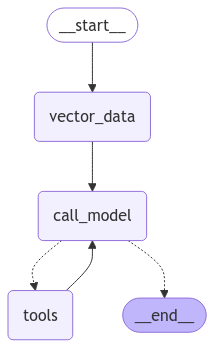

In [5]:
from langgraph.graph import MessagesState
from IPython.display import Image, display

tools = []

retriever = recreate_retriever()
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Search and return information for user query.",
)
tools.append(retriever_tool)


class State(MessagesState):
    query: str
    doc_path: Optional[str]  # Path of the document being processed
    
def vector_data(state: State):
    if "doc_path" in state:
        print('\n\n********** ADDING DATA TO VECTOR STORE **********\n\n')
        doc_path = state['doc_path']
        # Add documents
        process_docs_and_get_retriever(doc_path)
        return {'doc_path': ""}
    else:
        pass

def call_model(state: State):
    #global tools
    #tools.clear()
    messages = state["messages"]
    query = state["query"]
    sys_msg = SystemMessage(
        content="""You are a helpful assistant. 

    Your main task is to assist the user by providing accurate information using the retriever_tool. Always answer based only on the information retrieved with the retriever_tool.

    If you do not find the information needed to answer the user's question, clearly state: 
    'I do not have the information you are looking for.' 
    Then, politely ask the user to update the knowledge base with relevant details.

    Do not provide answers based on assumptions, external knowledge, or unsupported information. Always rely solely on the retrieved content."""
    )
    message = HumanMessage(content=query)
    messages.append(message)
    #print(f'*******WE SEND THIS TO LLM:\n\n{messages}\n*******')
    
    # Tool
    #retriever = recreate_retriever()
    #retriever_tool = create_retriever_tool(
    #    retriever,
    #    "retriever_tool",
    #    "Search and return information for user query.",
    #)
    #tools.append(retriever_tool)
    
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke([sys_msg] + messages)
    #print(f'AI RESPONSE: {response}')
    return {"messages": response}

workflow = StateGraph(State)
workflow.add_node("vector_data", vector_data)
workflow.add_node("call_model", call_model)
workflow.add_node("tools", ToolNode(tools))  # for the tools

workflow.set_entry_point('vector_data')
workflow.add_edge('vector_data', 'call_model')
workflow.add_conditional_edges(
    "call_model", tools_condition, path_map=["tools", "__end__"]
)
workflow.add_edge('tools', 'call_model')

memory = MemorySaver()
react_graph = workflow.compile(checkpointer=memory)
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [6]:
def call_graph(user_input, config, doc_path=None):
    """
    Processes the user input and document path with the graph.

    Args:
        user_input (str): The user's query.
        config (dict): Graph configuration including thread ID.
        doc_path (str, optional): Path to the document being processed.

    Returns:
        str: The response from the graph.
    """
    # Prepare the initial state
    state = {}

    # Add the query if it exists
    if user_input:
        state["query"] = user_input

    # Add `doc_path` if it exists
    if doc_path:
        state["doc_path"] = doc_path

    # Stream events from the graph
    events = react_graph.stream(state, config, stream_mode="values")

    response = None  # Initialize response
    for event in events:
        # Retrieve the last message content from the graph's output
        if "messages" in event and event["messages"]:
            response = event["messages"][-1].content

    return response


In [6]:
import uuid
thread_id_number = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_number}}

In [8]:
user_query = 'What is ASGM?'
response = call_graph(user_input=user_query, config=config)
print(response)

*******WE SEND THIS TO LLM:

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='3d730a95-bfbe-4266-b9ca-d51e1bc5efda'), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 343, 'total_tokens': 351, 'completion_time': 0.039406182, 'prompt_time': 0.049887338, 'queue_time': 0.007662730999999999, 'total_time': 0.08929352}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'stop', 'logprobs': None}, id='run-2dd81e57-3457-42d8-a091-65cc4e6c5c40-0', usage_metadata={'input_tokens': 343, 'output_tokens': 8, 'total_tokens': 351}), HumanMessage(content='What is ASGM?', additional_kwargs={}, response_metadata={})]
*******
*******WE SEND THIS TO LLM:

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='3d730a95-bfbe-4266-b9ca-d51e1bc5efda'), AIMessage(content='How can I assist you today?', additional_kwarg

In [ ]:
import gradio as gr
import uuid

# Generate a persistent thread ID once
thread_id_number = str(uuid.uuid4())

def process_user_input(message, file):
    global thread_id_number  # Ensure we're using the same thread ID across calls

    # Debug input
    print(f"DEBUG: Received message: {message}")
    print(f"DEBUG: Received file: {file}")

    # Reuse the existing thread ID for the graph configuration
    config = {"configurable": {"thread_id": thread_id_number}}

    # Extract user message
    user_text = message.get("text", "").strip() if message else ""

    # Extract doc_path from message["files"]
    doc_path = None
    if message and "files" in message and message["files"]:
        doc_path = message["files"][0]  # First file in the list

    # Call the graph with the extracted text and/or document path
    if user_text or doc_path:  # Ensure at least one input is provided
        try:
            response = call_graph(user_input=user_text, config=config, doc_path=doc_path)
            print(f"DEBUG: AI Response: {response}")

            # Return meaningful content
            if response and isinstance(response, str) and response.strip():
                return response
            else:
                return "I'm processing your request. Please wait for further results or actions."
        except Exception as e:
            print(f"ERROR: {e}")
            return "An error occurred while processing your request. Please try again."
    else:
        return "No message or document provided. Please send a query or attach a document."

# Gradio interface
with gr.Blocks() as app:
    chat_interface = gr.ChatInterface(
        fn=process_user_input,
        type="messages",
        multimodal=True,
        title="Multimodal Chatbot",
        description="Ask questions and optionally upload a document (PDF or DOCX)."
    )

# Launch the app
app.launch()


/Users/alex/Projects/Auto Flujo/Clientes/Upwork/Goldmine/venv_goldmine/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


DEBUG: Received message: {'text': '', 'files': ['/private/var/folders/by/d_cc6wt94_d8s97bw7brfc840000gn/T/gradio/2ee10b39b79824734f3699387449efd8fda0e606635a8cf0041d5045e11e856e/forza_pro.docx']}
DEBUG: Received file: []


********** ADDING DATA TO VECTOR STORE **********


ERROR: 'query'
